In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from datetime import datetime, timedelta
from tools import *
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook")
sns.color_palette("colorblind")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 35
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 45
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['xtick.labelsize'] = 25
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' + '\n'  + r'\usepackage{amssymb}'

In [5]:
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

<Figure size 432x288 with 0 Axes>

In [6]:
in_folder = "../data/input/sociopatterns/"
out_folder = "../data/output/sociopatterns/"

In [7]:
datasets = os.listdir(in_folder)

seeds = [697752728, 4190089612, 1176914559, 3077924848, 315917623, 2544020234, 1077758578, 4071300106, 534591752, 3553386411]
K_affs = [1,3,5,7,9,11]
folds = [0,1,2,3,4]
colors = ["red", "orange", "blue", "grey", "cyan"]

In [8]:
datasets

['workplace01', 'highschool', 'hospital', 'primary_school', 'workplace02']

training_Exp_1077758578_0_5.npz
../data/output/sociopatterns/workplace01/training_Exp_1077758578_0_5.npz


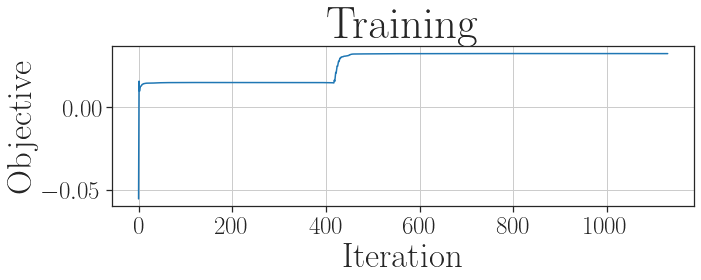

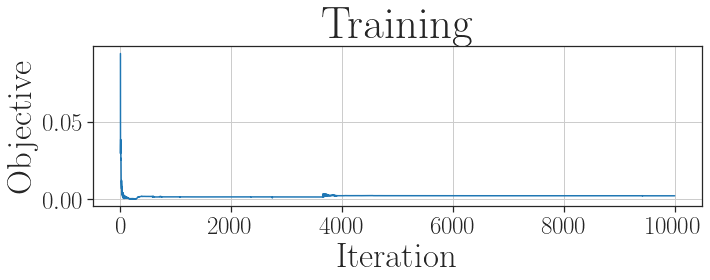

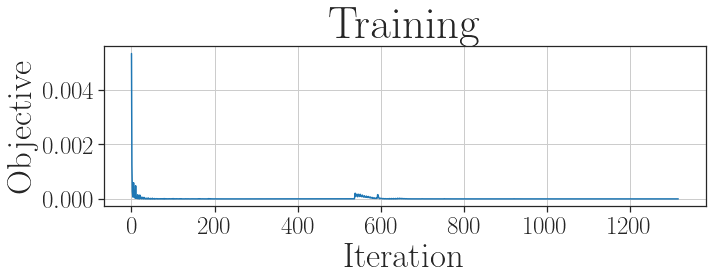

In [9]:
df = pd.DataFrame()

fold=0
dataset="workplace01"
K_aff=5

params = np.load(in_folder + dataset + "/params.npz")
mu, Z = params["u"], params["Z"]
data = read_data(in_folder + dataset + "/", "data")
masks = np.load(in_folder + dataset +"/mask.npz")["mask"]
T = masks.shape[1]
mask = masks[fold]


'''
    determine best seeds for each run
'''
best_score_noexp = -1e10
seed_noexp = seeds[0]

best_score_exp = -1e10
seed_exp = seeds[0]

for seed in seeds: 
    training_noexp = f"training_NoExp_{seed}_{fold}_{K_aff}.npz"  
    score_noexp = np.load(out_folder + dataset + "/" + training_noexp)["losses"][-1]
    if score_noexp > best_score_noexp: 
        best_score_noexp = score_noexp
        seed_noexp = seed

    training_exp = f"training_Exp_{seed}_{fold}_{K_aff}.npz"
    score_exp = np.load(out_folder + dataset + "/" + training_exp)["losses"][-1]
    if score_exp > best_score_exp: 
        best_score_exp = score_exp
        seed_exp = seed        

training_exp = f"training_Exp_{seed_exp}_{fold}_{K_aff}.npz"
print(training_exp)
losses = np.load(out_folder + dataset + "/" + training_exp)
print(out_folder + dataset + "/" + training_exp)

plot_losses(losses["losses"])
plot_losses(losses["theta_errors"])
plot_losses(losses["exp_errors"])

In [10]:
for key in losses.keys():
    print(key)

losses
theta_errors
exp_errors


NoExp, fold=0:  K_aff=5 AUC_A= 0.8608991775830221
Exp, fold=0, K_aff=5:  AUC_A:  0.636146522759558 acc_mu= 0.5090395294217188 AUC_Q=0.4408163522058083
K_aff: 5


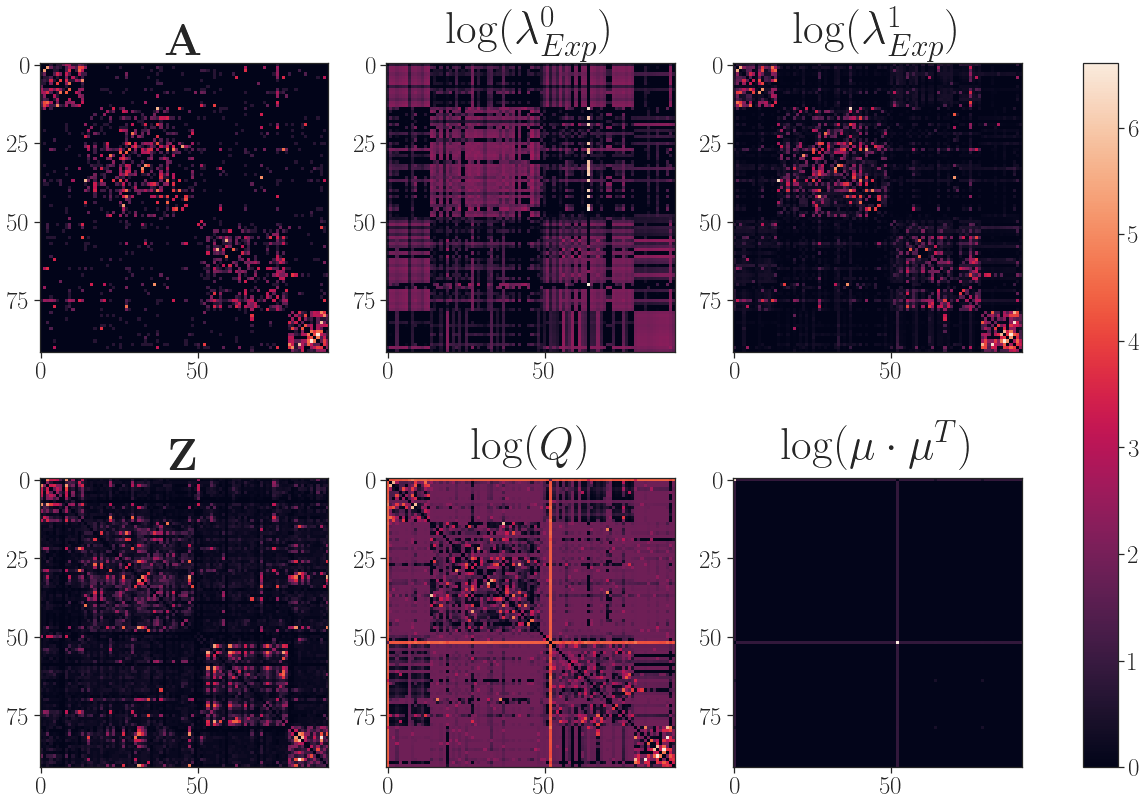

In [11]:
params = np.load(in_folder + dataset + "/params.npz")
mu, Z = params["u"], params["Z"]
data = read_data(in_folder + dataset + "/", "data")
masks = np.load(in_folder + dataset +"/mask.npz")["mask"]
T = masks.shape[1]
mask = masks[fold]

'''
    evaluate and store NoExp results
'''            
file_noexp = f"params_NoExp_{seed_noexp}_{fold}_{K_aff}.npz"
params_noexp = np.load(out_folder + dataset + "/" + file_noexp)
u_noexp, v_noexp, w_noexp = params_noexp["u"], params_noexp["v"], params_noexp["w"]
lam_noexp = u_noexp @ w_noexp @ v_noexp.T
lam_noexp = np.array([lam_noexp]*T)
AUC_A = calculate_AUC(data>0, lam_noexp, mask=mask)
df = df.append({"dataset": dataset, "Exp": 0, "fold": fold, "K_aff": K_aff, "seed": seed_noexp, "AUC_A": AUC_A}, ignore_index=True)
print(f"NoExp, fold={fold}: ", f"K_aff={K_aff}", "AUC_A=", AUC_A)     


'''
    evaluate and store Exp results
'''
file_exp = f"params_Exp_{seed_exp}_{fold}_{K_aff}.npz"
params_exp = np.load(out_folder + dataset + "/" + file_exp)
u_exp, v_exp, w_exp, mu_exp, Q = params_exp["u"], params_exp["v"], params_exp["w"], params_exp["mu"], params_exp["Q"]
lam_exp = u_exp @ w_exp @ v_exp.T
lam_exp_0 = np.array([lam_exp]*T)
lam_exp_1 = lam_exp_0 * Q
AUC_A = calculate_AUC(data>0, lam_exp_1, mask=mask)
acc_mu = evaluate_memberships(mu, mu_exp, mu, mu_exp)[0]
AUC_Q = calculate_AUC(Z, Q)
df = df.append({"dataset": dataset, "Exp": 1, "fold": fold, "seed": seed_exp, "K_aff": K_aff, "AUC_A": AUC_A, "acc_mu": acc_mu, "AUC_Q": AUC_Q}, ignore_index=True)
print(f"Exp, fold={fold}, K_aff={K_aff}: ", "AUC_A: ", AUC_A, "acc_mu=", acc_mu, f"AUC_Q={AUC_Q}")



'''
    visualize performance for each dataset and fold 0
'''
print_bold(f"K_aff: {K_aff}")
fig, axs = plt.subplots(2,3,figsize=(22,14))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

im = axs[0][0].imshow(np.log(data.sum(axis=0)+1))
#axs[0][0].xaxis.tick_top() 
axs[0][0].set_title("\\textbf{A}")  

axs[0][1].imshow((np.log(lam_exp_0.sum(axis=0)+1)))
#axs[0][1].xaxis.tick_top()
axs[0][1].set_title("$\log(\lambda_{Exp}^0)$", pad=20)

axs[0][2].imshow(np.log(lam_exp_1.sum(axis=0)+1))
#axs[0][2].xaxis.tick_top()
axs[0][2].set_title("$\log(\lambda_{Exp}^1)$", pad=20)


axs[1][0].imshow(Z.sum(axis=0))
#axs[1][0].xaxis.tick_top()
axs[1][0].set_title("\\textbf{Z}")

axs[1][1].imshow(np.log(Q.sum(axis=0)+1))
#axs[1][1].xaxis.tick_top()
axs[1][1].set_title("$\log(Q)$", pad=20)

axs[1][2].imshow(np.log(np.log(mu_exp@mu_exp.T +1)+1))
#axs[1][2].xaxis.tick_top()
axs[1][2].set_title("$\log(\mu\cdot\mu^T)$", pad=20)

plt.setp(axs, yticks=plt.xticks()[0][1:-1])

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.925)
#cbar.set_ticks(np.arange(0, 1.1, 0.5))
#cbar.set_ticklabels(['low', 'medium', 'high'])

#plt.savefig(f"figures/{dataset}.png", bbox_inches="tight", dpi=300)
plt.show()

workplace01
NoExp, fold=0:  K_aff=1 acc_u=  0.0 AUC_A= 0.7238205593118805
Exp, fold=0, K_aff=1:  AUC_A=0.41141784606824805 acc_u=0.0  acc_mu= 0.5148537436940045 AUC_Q=0.506357340928529
K_aff: 1


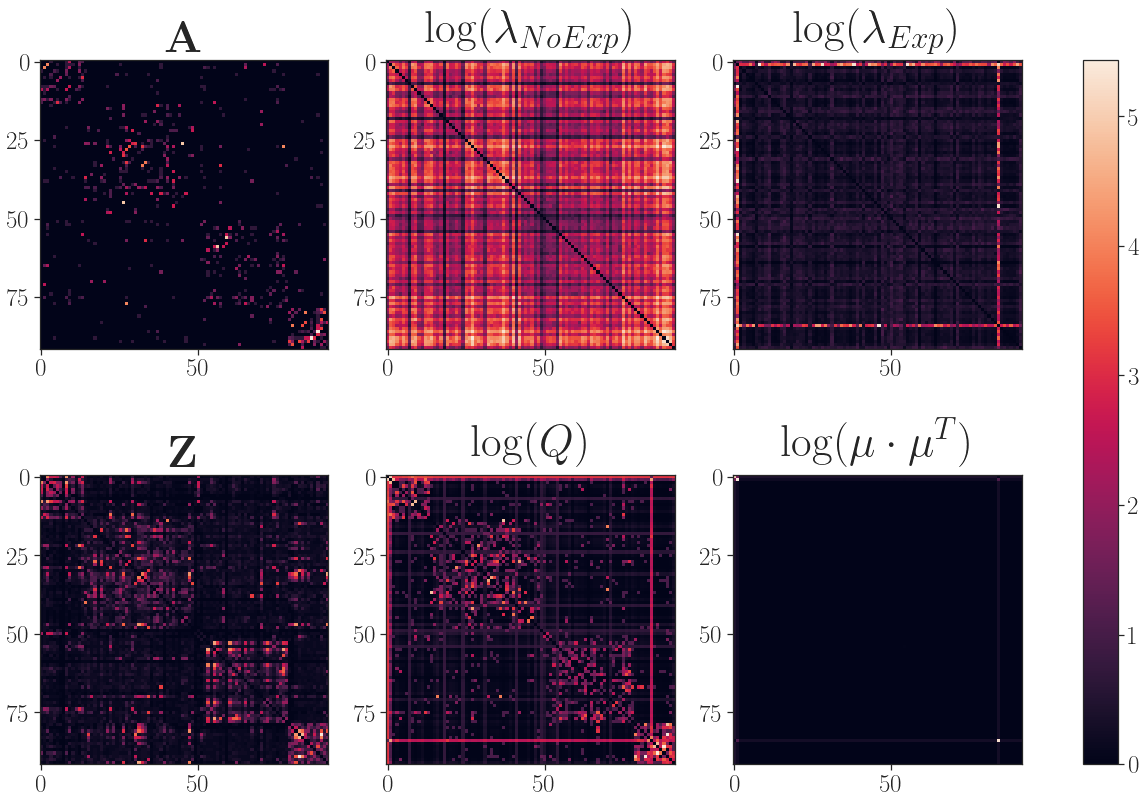

NoExp, fold=0:  K_aff=3 acc_u=  0.0 AUC_A= 0.8550208574158233
Exp, fold=0, K_aff=3:  AUC_A=0.5883606033725882 acc_u=0.0  acc_mu= 0.4979422189374218 AUC_Q=0.4633649969975609
K_aff: 3


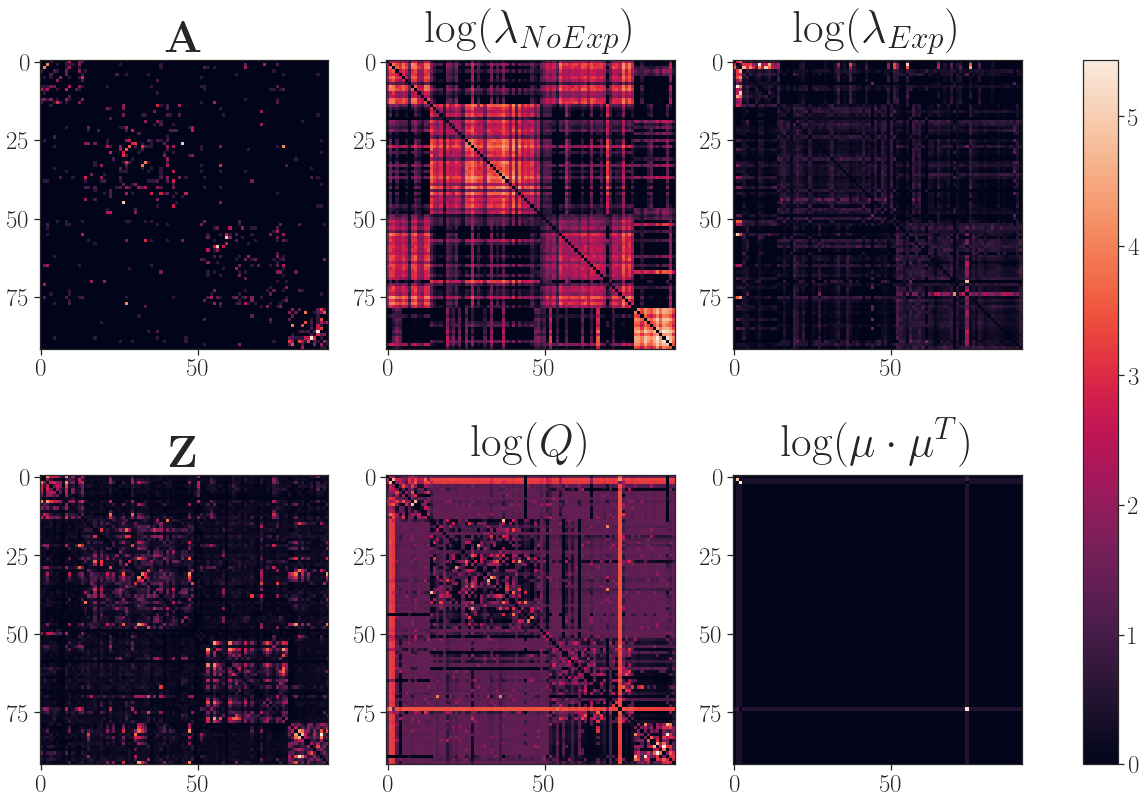

NoExp, fold=0:  K_aff=5 acc_u=  0.8683912273903729 AUC_A= 0.8608991775830221
Exp, fold=0, K_aff=5:  AUC_A=0.636146522759558 acc_u=0.5610921611334176  acc_mu= 0.5090395294217188 AUC_Q=0.4408163522058083
K_aff: 5


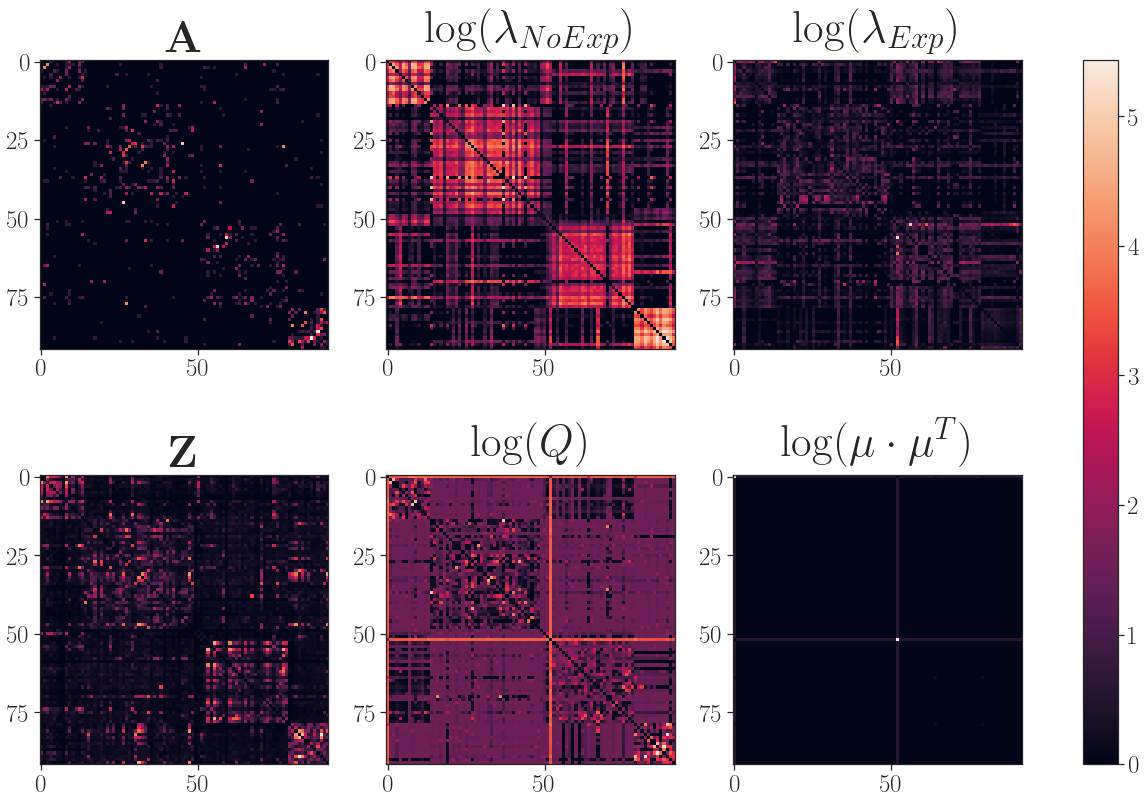

NoExp, fold=0:  K_aff=7 acc_u=  0.0 AUC_A= 0.857110945776097
Exp, fold=0, K_aff=7:  AUC_A=0.6822501797634899 acc_u=0.0  acc_mu= 0.49893342382343225 AUC_Q=0.4210469198724727
K_aff: 7


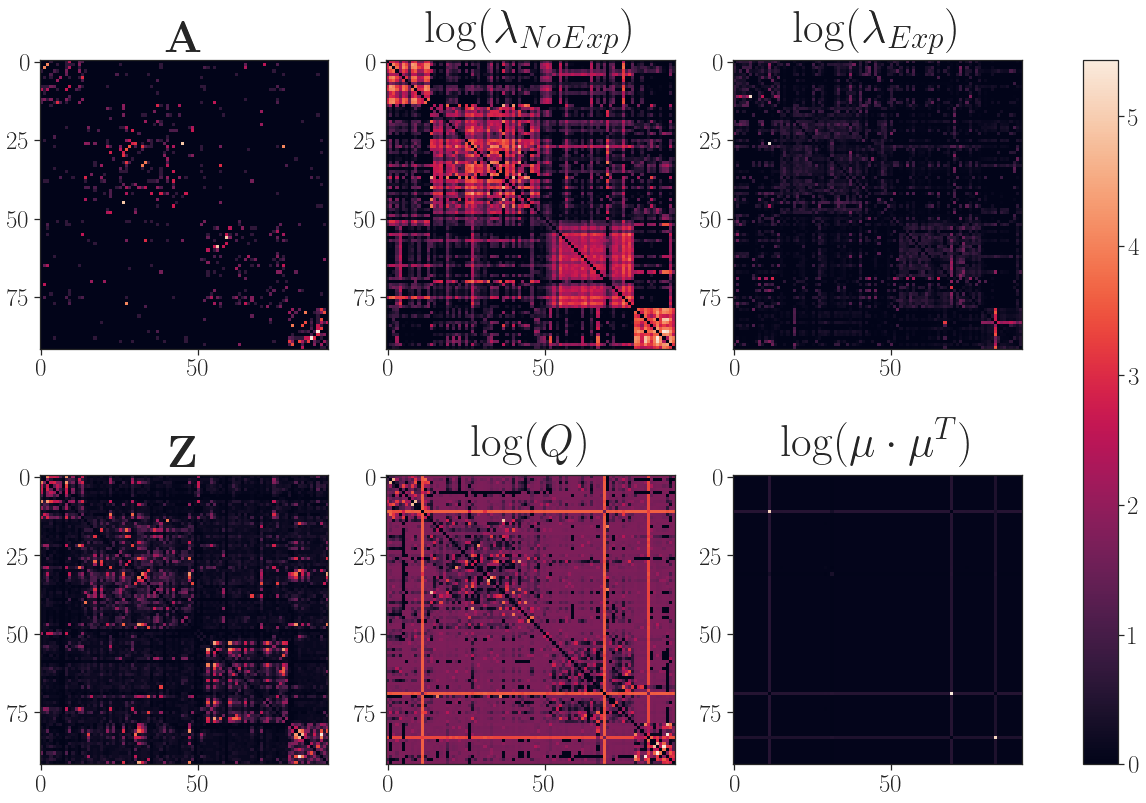

NoExp, fold=0:  K_aff=9 acc_u=  0.0 AUC_A= 0.8638055835908268
Exp, fold=0, K_aff=9:  AUC_A=0.6980291352892353 acc_u=0.0  acc_mu= 0.5029108691383771 AUC_Q=0.4292125041069236
K_aff: 9


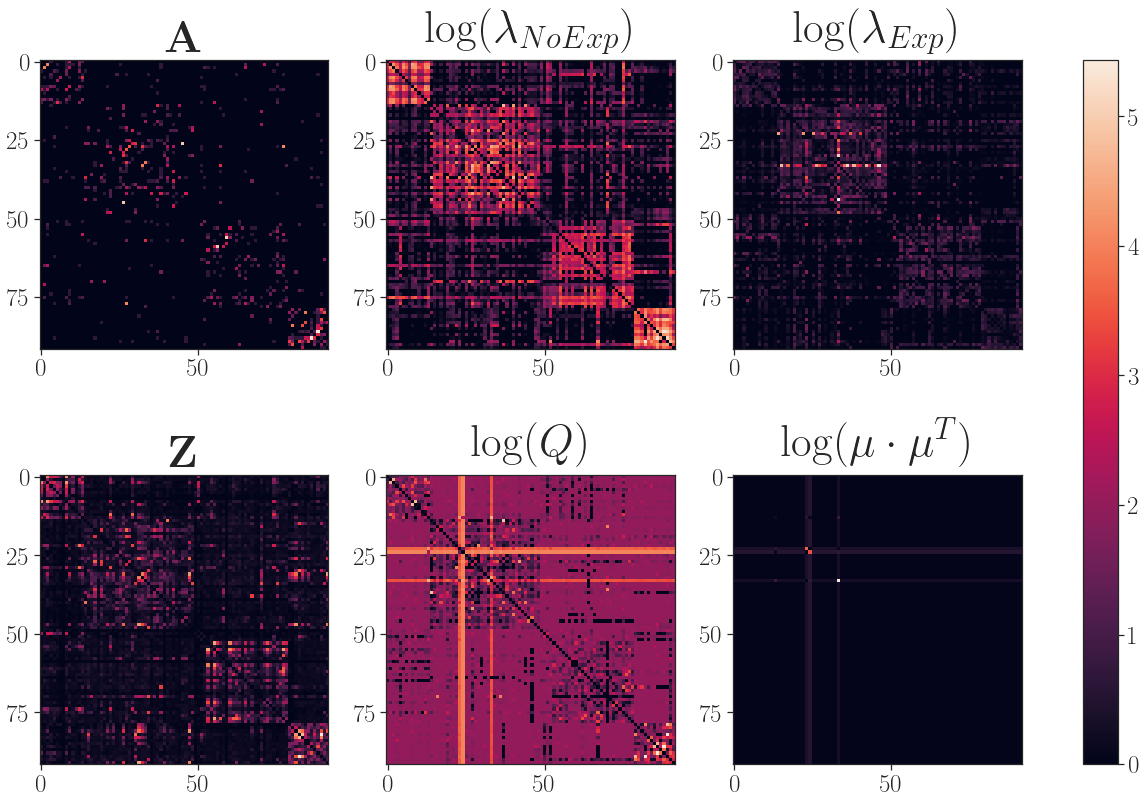

NoExp, fold=0:  K_aff=11 acc_u=  0.0 AUC_A= 0.8673724362051182
Exp, fold=0, K_aff=11:  AUC_A=0.7213813907390471 acc_u=0.0  acc_mu= 0.4863128407957234 AUC_Q=0.41586890672947574
K_aff: 11


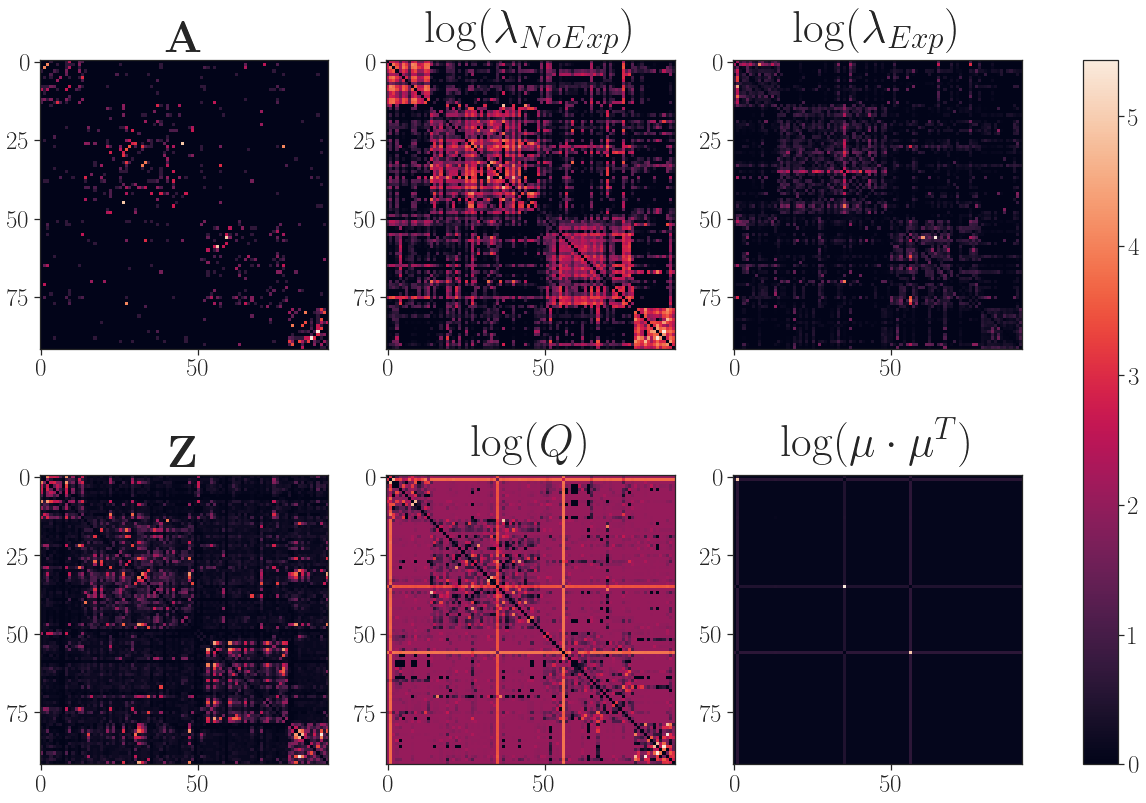

NoExp, fold=1:  K_aff=1 acc_u=  0.0 AUC_A= 0.7267139459726216
Exp, fold=1, K_aff=1:  AUC_A=0.3960455740869496 acc_u=0.0  acc_mu= 0.50543066400121 AUC_Q=0.4901616950062156
NoExp, fold=1:  K_aff=3 acc_u=  0.0 AUC_A= 0.8578299741228039
Exp, fold=1, K_aff=3:  AUC_A=0.5916487521894069 acc_u=0.0  acc_mu= 0.45234714904632695 AUC_Q=0.43216834665820925
NoExp, fold=1:  K_aff=5 acc_u=  0.8205028509636237 AUC_A= 0.8704215217953502
Exp, fold=1, K_aff=5:  AUC_A=0.6624725112831682 acc_u=0.7732573479843663  acc_mu= 0.49386313861817815 AUC_Q=0.43899920978951
NoExp, fold=1:  K_aff=7 acc_u=  0.0 AUC_A= 0.8734881678902717
Exp, fold=1, K_aff=7:  AUC_A=0.6886261875943291 acc_u=0.0  acc_mu= 0.4908681617883083 AUC_Q=0.42949334061234035
NoExp, fold=1:  K_aff=9 acc_u=  0.0 AUC_A= 0.8738220139778851
Exp, fold=1, K_aff=9:  AUC_A=0.7253428033262433 acc_u=0.0  acc_mu= 0.4778053979500794 AUC_Q=0.4404290015258115
NoExp, fold=1:  K_aff=11 acc_u=  0.0 AUC_A= 0.8651273855855659
Exp, fold=1, K_aff=11:  AUC_A=0.7193435321

In [29]:
df = pd.DataFrame()

for dataset in datasets: 
    if dataset != "workplace01": 
        continue
    print_bold(dataset)
    dataset_files = os.listdir(out_folder + dataset)
    params = np.load(in_folder + dataset + "/params.npz")
    u, Z = params["u"], params["Z"]
    K_exp = u.shape[1]
    data = read_data(in_folder + dataset + "/", "data")
    masks = np.load(in_folder + dataset +"/mask.npz")["mask"]
    T = masks.shape[1]
    
    for fold in folds: 
        mask = masks[fold]
        for K_aff in K_affs: 
            acc_u, acc_v = 0, 0
            '''
                determine best seeds for each run
            '''
            best_score_noexp = -1e10
            seed_noexp = seeds[0]

            best_score_exp = -1e10
            seed_exp = seeds[0]

            for seed in seeds: 
                training_noexp = f"training_NoExp_{seed}_{fold}_{K_aff}.npz"  
                score_noexp = np.load(out_folder + dataset + "/" + training_noexp)["losses"][-1]
                if score_noexp > best_score_noexp: 
                    best_score_noexp = score_noexp
                    seed_noexp = seed

                training_exp = f"training_Exp_{seed}_{fold}_{K_aff}.npz"
                if training_exp in dataset_files: 
                    score_exp = np.load(out_folder + dataset + "/" + training_exp)["losses"][-1]
                    if score_exp > best_score_exp: 
                        best_score_exp = score_exp
                        seed_exp = seed        


            '''
                evaluate and store NoExp results
            '''            
            file_noexp = f"params_NoExp_{seed_noexp}_{fold}_{K_aff}.npz"
            params_noexp = np.load(out_folder + dataset + "/" + file_noexp)
            u_noexp, v_noexp, w_noexp = params_noexp["u"], params_noexp["v"], params_noexp["w"]
            if K_exp == K_aff: 
                acc_u, acc_v, _, _ = evaluate_memberships(u, u_noexp, u, v_noexp)
            lam_noexp = u_noexp @ w_noexp @ v_noexp.T
            lam_noexp = np.array([lam_noexp]*T)
            AUC_A = calculate_AUC(data>0, lam_noexp, mask=mask)
            df = df.append({"dataset": dataset, "Exp": 0, "fold": fold, "K_aff": K_aff, "seed": seed_noexp, "acc_u": (acc_u+acc_v)/2, "AUC_A": AUC_A}, ignore_index=True)
            print(f"NoExp, fold={fold}: ", f"K_aff={K_aff}", "acc_u= ", (acc_u+acc_v)/2, "AUC_A=", AUC_A)     


            '''
                evaluate and store Exp results
            '''
            file_exp = f"params_Exp_{seed_exp}_{fold}_{K_aff}.npz"
            params_exp = np.load(out_folder + dataset + "/" + file_exp)
            u_exp, v_exp, w_exp, mu_exp, Q = params_exp["u"], params_exp["v"], params_exp["w"], params_exp["mu"], params_exp["Q"]
            lam_exp = u_exp @ w_exp @ v_exp.T
            lam_exp_0 = np.array([lam_exp]*T)
            lam_exp_1 = lam_exp_0 * Q
            AUC_A = calculate_AUC(data>0, lam_exp_1, mask= mask)
            acc_mu = evaluate_memberships(u, mu_exp, u, mu_exp)[0]
            if K_exp == K_aff: 
                acc_u, acc_v, _, _ = evaluate_memberships(u, u_exp, u, v_exp)
            AUC_Q = calculate_AUC(Z, Q)
            df = df.append({"dataset": dataset, "Exp": 1, "fold": fold, "seed": seed_exp, "K_aff": K_aff, "AUC_A": AUC_A, "acc_u": (acc_u+acc_v)/2, "acc_mu": acc_mu, "AUC_Q": AUC_Q}, ignore_index=True)
            print(f"Exp, fold={fold}, K_aff={K_aff}: ", f"AUC_A={AUC_A}", f"acc_u={(acc_u+acc_v)/2} ", "acc_mu=", acc_mu, f"AUC_Q={AUC_Q}")
       
    
    
            '''
                visualize performance for each dataset and fold 0
            '''
            if fold == 0:
                print_bold(f"K_aff: {K_aff}")
                fig, axs = plt.subplots(2,3,figsize=(22,14))
                plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
                
                im = axs[0][0].imshow(np.log((data*mask).sum(axis=0)+1))
                #axs[0][0].xaxis.tick_top() 
                axs[0][0].set_title("\\textbf{A}")  

                axs[0][1].imshow((np.log((lam_noexp*mask).sum(axis=0)+1)))
                #axs[0][1].xaxis.tick_top()
                axs[0][1].set_title("$\log(\lambda_{NoExp})$", pad=20)

                axs[0][2].imshow(np.log((lam_exp_1*mask).sum(axis=0)+1))
                #axs[0][2].xaxis.tick_top()
                axs[0][2].set_title("$\log(\lambda_{Exp})$", pad=20)


                axs[1][0].imshow(Z.sum(axis=0))
                #axs[1][0].xaxis.tick_top()
                axs[1][0].set_title("\\textbf{Z}")

                axs[1][1].imshow(np.log(Q.sum(axis=0)+1))
                #axs[1][1].xaxis.tick_top()
                axs[1][1].set_title("$\log(Q)$", pad=20)

                axs[1][2].imshow(np.log(mu_exp@mu_exp.T +1))
                #axs[1][2].xaxis.tick_top()
                axs[1][2].set_title("$\log(\mu\cdot\mu^T)$", pad=20)

                plt.setp(axs, yticks=plt.xticks()[0][1:-1])

                cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.925)
                #cbar.set_ticks(np.arange(0, 1.1, 0.5))
                #cbar.set_ticklabels(['low', 'medium', 'high'])

                #plt.savefig(f"figures/{dataset}.png", bbox_inches="tight", dpi=300)
                plt.show()

        

## Analyzing AUC Q

In [13]:
dataset_titles = {"highschool": "Highschool", "primary_school": "Primary School", "hospital": "Hospital", "workplace01": "Workplace01", "workplace02": "Workplace02"}

In [14]:
Q_stats = pd.DataFrame()
for dataset in datasets: 
    vals = df.loc[(df["dataset"] == dataset) & (df["Exp"]==1)]["AUC_Q"].to_numpy()
    print(vals)
    mean, var = mean_confidence_interval(vals)
    Q_stats = Q_stats.append({"": dataset_titles[dataset], "Mean":np.round(mean, 4), "Variance":np.round(var, 4)}, ignore_index=True) 

[0.50635734 0.463365   0.44081635 0.42104692 0.4292125  0.41586891
 0.4901617  0.43216835 0.43899921 0.42949334 0.440429   0.41160251
 0.5109201  0.43079328 0.42920318 0.44450979 0.42580056 0.42174883
 0.50626243 0.44042361 0.43216414 0.40888779 0.42466409 0.41878712
 0.50801531 0.44317348 0.40960342 0.42266885 0.42554915 0.43588889]
[]
[]
[]
[]


## Scatter Plot for the link prediction

In [15]:
print(datasets)
labels = ["Workplace01", "Highschool", "Hospital", "PrimarySchool", "Workplace02"]
markers = ["*", "d", "v", "+", "p"]

['workplace01', 'highschool', 'hospital', 'primary_school', 'workplace02']


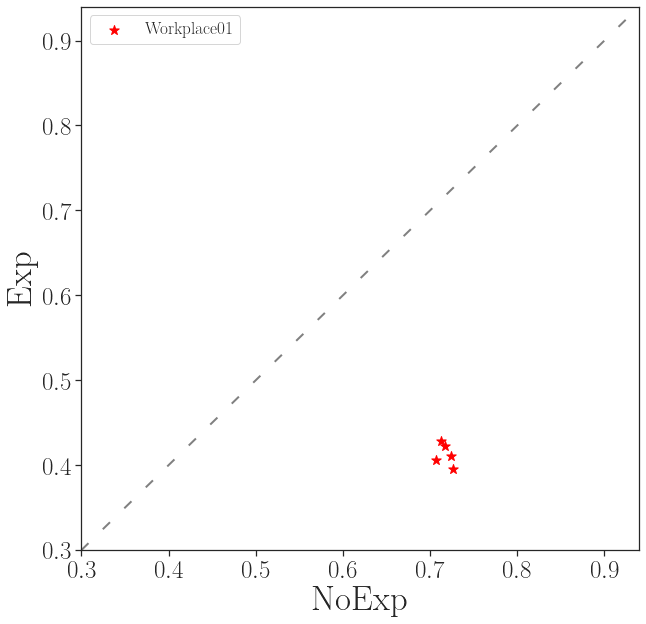

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
#plt.title("$AUC(A, \lambda_{NoExp})\ vs.\ AUC(A, \lambda_{Exp})$", pad=15)
#plt.title("Link Prediction")
ax.set_xlabel("NoExp")
ax.set_ylabel("Exp")



for i,dataset in enumerate(datasets): 
    if dataset != "workplace01":
        continue
    for fold in folds: 
        x = df.loc[(df["dataset"] == dataset) & (df["fold"] == fold) & (df["Exp"] == 0)]["AUC_A"].to_numpy()[0]
        y = df.loc[(df["dataset"] == dataset) & (df["fold"] == fold) & (df["Exp"] == 1)]["AUC_A"].to_numpy()[0]
        plt.scatter(x,y,color="green" if y>x else "red", marker=markers[i], s=100, label=labels[i] if fold==0 else "")
ax.plot(np.arange(0.3,0.95,0.01), np.arange(0.3,0.95,0.01), color="grey", ls=(0, (5, 10)),lw=2)
ax.margins(x=0,y=0)
plt.legend(fontsize="xx-large")
#plt.savefig("figures/link_prediction.png", bbox_inches="tight", dpi=300)
plt.show()

## Membership Predictions

IndexError: index 0 is out of bounds for axis 0 with size 0

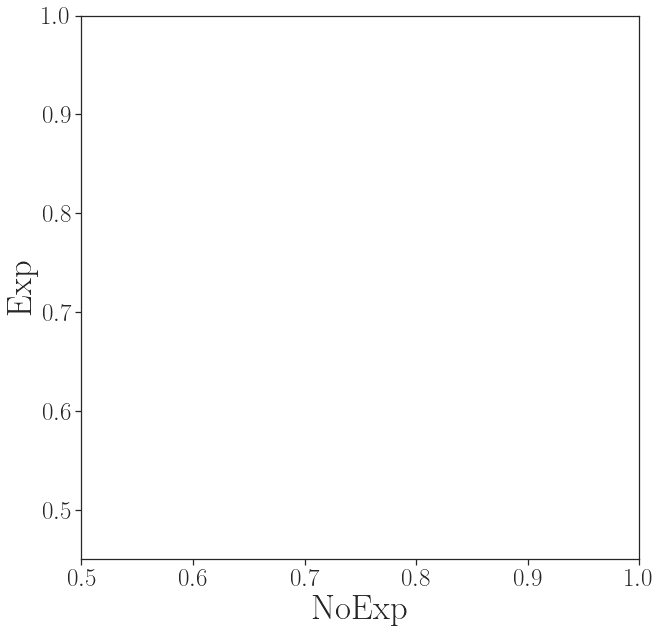

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
#plt.title("Membership Predictions", pad=15)
ax.set_xlabel("NoExp")
ax.set_ylabel("Exp")

ax.set_xlim([0.5,1])
ax.set_ylim([0.45,1])

for i,dataset in enumerate(datasets): 
    for fold in folds: 
        x = df.loc[(df["dataset"] == dataset) & (df["fold"] == fold) & (df["Exp"] == 0)]["acc_u"].to_numpy()[0]
        y = df.loc[(df["dataset"] == dataset) & (df["fold"] == fold) & (df["Exp"] == 1)]["acc_mu"].to_numpy()[0]
        plt.scatter(x,y,color="green" if y>x else "red", marker=markers[i], s=100, label=labels[i] if fold==0 else "")
ax.plot(np.arange(0.5, 1, 0.01), np.arange(0.5, 1,0.01), color="grey", ls=(0, (5, 10)),lw=2)
ax.margins(x=0,y=0)
plt.legend(fontsize="xx-large")
plt.savefig("figures/memberships.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
df.loc[(df["Exp"] == 1)]["AUC_Q"].mean()

In [ ]:
df.loc[(df["Exp"] == 1)]["AUC_A"].mean()

# Membership Predictions $u$

IndexError: index 0 is out of bounds for axis 0 with size 0

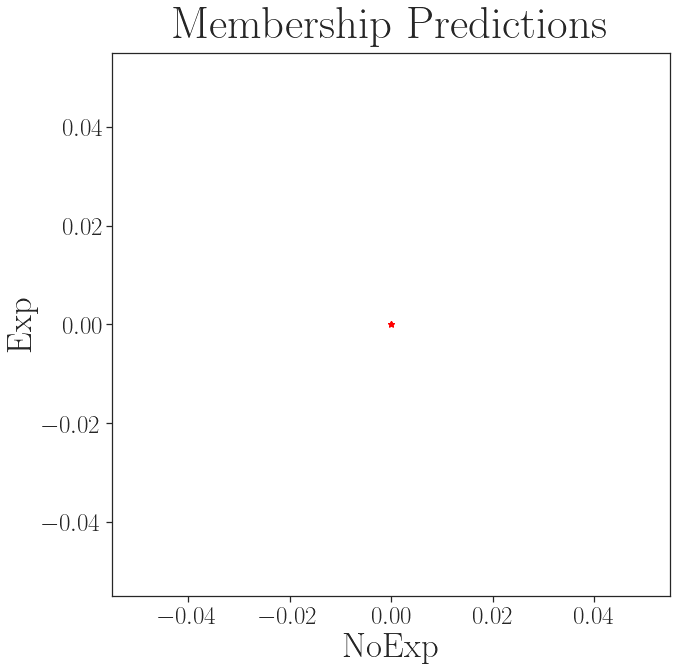

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title("Membership Predictions", pad=15)
ax.set_xlabel("NoExp")
ax.set_ylabel("Exp")

for i,dataset in enumerate(datasets): 
    for fold in folds: 
        x = df.loc[(df["dataset"] == dataset) & (df["fold"] == fold) & (df["Exp"] == 0)]["acc_u"].to_numpy()[0]
        y = df.loc[(df["dataset"] == dataset) & (df["fold"] == fold) & (df["Exp"] == 1)]["acc_u"].to_numpy()[0]
        plt.scatter(x,y,color="green" if y>x else "red", marker=markers[i], label=labels[i] if fold==0 else "")
ax.plot(np.arange(0.5, 1, 0.01), np.arange(0.5, 1,0.01), color="red", ls='-.',lw=0.5)
plt.legend()
#plt.savefig("figures/memberships_None.svg")
plt.show()